# IMU_THM_TOF training notebook

### 1: import IMU_THM_TOF data

In [2]:
# import variables
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Masking, BatchNormalization, LSTM, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# scaled data
train_IMU_THM_TOF_scaled = np.load('../input/cmi-ocd-variables/variables/train_IMU_THM_TOF_scaled.npy')
test_IMU_THM_TOF_scaled = np.load('../input/cmi-ocd-variables/variables/test_IMU_THM_TOF_scaled.npy')
val_IMU_THM_TOF_scaled = np.load('../input/cmi-ocd-variables/variables/val_IMU_THM_TOF_scaled.npy')

# unscaled data
train_IMU_THM_TOF_prescaled = pd.read_csv('../input/cmi-ocd-variables/variables/train_IMU_THM_TOF_prescaled.csv')
test_IMU_THM_TOF_prescaled = pd.read_csv('../input/cmi-ocd-variables/variables/test_IMU_THM_TOF_prescaled.csv')
val_IMU_THM_TOF_prescaled = pd.read_csv('../input/cmi-ocd-variables/variables/val_IMU_THM_TOF_prescaled.csv')

2025-11-16 04:48:33.288840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763268513.524565      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763268513.588610      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# list feature names for train and test
print("Training/Validation features:")
print(train_IMU_THM_TOF_prescaled.columns.to_list())
print("\nTest features:")
print(test_IMU_THM_TOF_prescaled.columns.to_list())

Training/Validation features:
['sequence_id', 'gesture', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'acc_mag', 'lin_acc_mag', 'acc_mag_jerk', 'lin_acc_mag_jerk', 'rot_angle', 'angular_distance', 'rot_angle_vel', 'angular_vel_x', 'angular_vel_y', 'angular_vel_z', 'acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5', 'tof_1_v0', 'tof_1_v1', 'tof_1_v2', 'tof_1_v3', 'tof_1_v4', 'tof_1_v5', 'tof_1_v6', 'tof_1_v7', 'tof_1_v8', 'tof_1_v9', 'tof_1_v10', 'tof_1_v11', 'tof_1_v12', 'tof_1_v13', 'tof_1_v14', 'tof_1_v15', 'tof_1_v16', 'tof_1_v17', 'tof_1_v18', 'tof_1_v19', 'tof_1_v20', 'tof_1_v21', 'tof_1_v22', 'tof_1_v23', 'tof_1_v24', 'tof_1_v25', 'tof_1_v26', 'tof_1_v27', 'tof_1_v28', 'tof_1_v29', 'tof_1_v30', 'tof_1_v31', 'tof_1_v32', 'tof_1_v33', 'tof_1_v34', 'tof_1_v35', 'tof_1_v36', 'tof_1_v37', 'tof_1_v38', 'tof_1_v39', 'tof_1_v40', 'tof_1_v41', 'tof_1_v42', 'tof_1_v43', 'tof_1_v44', 'tof_1_v45', 'tof_1_v46', 'tof_1_v47', 'tof_1_v48', 'tof_1

### 2: sequence data

In [4]:
train_IMU_THM_TOF_prescaled = train_IMU_THM_TOF_prescaled.reset_index(drop=True)
test_IMU_THM_TOF_prescaled = test_IMU_THM_TOF_prescaled.reset_index(drop=True)
val_IMU_THM_TOF_prescaled = val_IMU_THM_TOF_prescaled.reset_index(drop=True)

# sequence train data
grouped_train = train_IMU_THM_TOF_prescaled.groupby('sequence_id')
sequences_train = []
labels_train = []
for sequence_id, group in grouped_train:
    indices_train = group.index.to_list()
    # Get all features
    current_sequence_data = train_IMU_THM_TOF_scaled[indices_train]
    # Select all features *except* the one at index 1 ('gesture')
    features_only = np.delete(current_sequence_data, 1, axis=1)
    sequences_train.append(features_only)
    
    label_train = group['gesture'].iloc[0]
    labels_train.append(label_train)

# sequence test data
grouped_test = test_IMU_THM_TOF_prescaled.groupby('sequence_id')
sequences_test = []
for sequence_id, group in grouped_test:
    indices_test = group.index.to_list()
    # Get all features
    current_sequence_data = test_IMU_THM_TOF_scaled[indices_test]
    # --- THIS IS THE FIX ---
    # NEW: Select all features *except* the one at index 1
    features_only = np.delete(current_sequence_data, 1, axis=1)
    sequences_test.append(features_only)
    # --- END OF FIX ---

# sequence val data
grouped_val = val_IMU_THM_TOF_prescaled.groupby('sequence_id')
sequences_val = []
labels_val = []
for sequence_id, group in grouped_val:
    indices_val = group.index.to_list()
    # Get all features
    current_sequence_data = val_IMU_THM_TOF_scaled[indices_val]
    # Select all features *except* the one at index 1 ('gesture')
    features_only = np.delete(current_sequence_data, 1, axis=1)
    sequences_val.append(features_only)
    
    label_val = group['gesture'].iloc[0]
    labels_val.append(label_val)

In [5]:
# pad data
def pad_data(sequences, max_length=None):
    padded_sequences = pad_sequences(sequences, padding='post', dtype='float32', maxlen=700)
    return padded_sequences

train_padded = pad_data(sequences_train)
test_padded = pad_data(sequences_test)
val_padded = pad_data(sequences_val)

y_train = np.array(labels_train)
y_val = np.array(labels_val)

print("Shape of the final padded data:", train_padded.shape) 
print("Shape of the final padded data:", test_padded.shape) 
print("Shape of the final padded data:", val_padded.shape) 

Shape of the final padded data: (6336, 700, 344)
Shape of the final padded data: (2, 700, 344)
Shape of the final padded data: (1584, 700, 344)


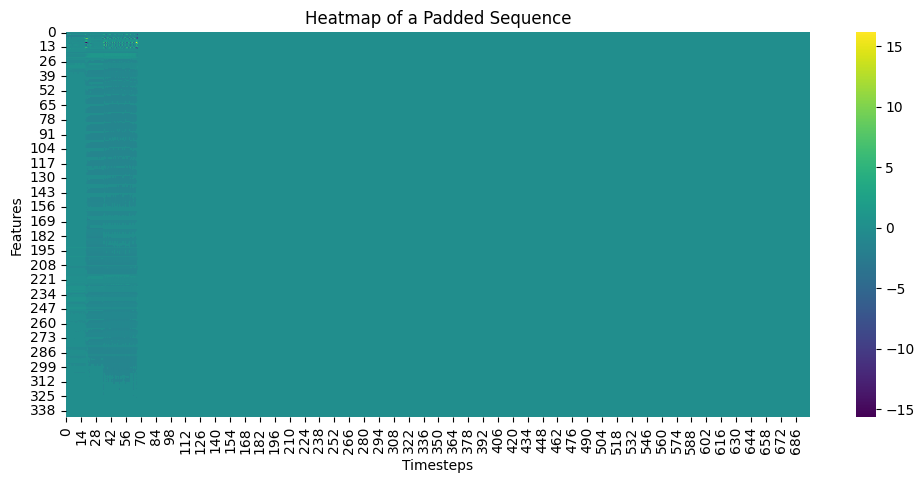

In [6]:
# select a sample to view (the first one)
sample_to_view = train_padded[1]

# create the heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(sample_to_view.T, cmap='viridis')
plt.title('Heatmap of a Padded Sequence')
plt.xlabel('Timesteps')
plt.ylabel('Features')
plt.show()

In [7]:
dummy_clf = DummyClassifier(strategy="most_frequent")

# initialize and fit encoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)

dummy_clf.fit(train_padded, y_train)

# predict on the validation set
y_val_pred_dummy = dummy_clf.predict(val_padded)

# calculate baseline accuracy
baseline_accuracy = accuracy_score(y_val, y_val_pred_dummy)
print(f"Baseline (Most Frequent) Accuracy: {baseline_accuracy * 100:.2f}%")

Baseline (Most Frequent) Accuracy: 7.45%


In [8]:
# set variables
num_timesteps = 700 
num_features = 344
num_classes = 18

# define model
model = Sequential([
    # block 1 
    Conv1D(filters=128, kernel_size=7, activation='relu', kernel_regularizer=l2(0.001), input_shape=(num_timesteps, num_features)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # block 2 
    Conv1D(filters=256, kernel_size=5, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # block 3
    Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    
    # block 4
    Conv1D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    
    # block 5
    Conv1D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    GlobalMaxPooling1D(),  # Alternative to MaxPooling1D + Flatten
    Dropout(0.4),
    
    # dense layers
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])

# compile model
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1763268568.515258      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763268568.516010      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 694, 128)       │       308,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 694, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 347, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 347, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 343, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 343, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 171, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 171, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 169, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 169, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 84, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 84, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 82, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 82, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 41, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 41, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 39, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 39, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             

 Total params: 2,285,842 (8.72 MB)

 Trainable params: 2,282,514 (8.71 MB)

 Non-trainable params: 3,328 (13.00 KB)

In [9]:
# re-encode and re-define as new variables
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

print("Labels successfully encoded.")

Labels successfully encoded.


Training model...
Epoch 1/200


I0000 00:00:1763268592.596264     106 service.cc:148] XLA service 0x796b18002f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763268592.597128     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763268592.597148     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763268593.414395     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/198 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.0312 - loss: 17.8696    

I0000 00:00:1763268602.200035     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


198/198 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.0739 - loss: 7.6978 - val_accuracy: 0.0751 - val_loss: 5.2720 - learning_rate: 0.0010
Epoch 2/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.0784 - loss: 5.2665 - val_accuracy: 0.1149 - val_loss: 4.9589 - learning_rate: 0.0010
Epoch 3/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.1247 - loss: 4.8940 - val_accuracy: 0.1484 - val_loss: 4.4905 - learning_rate: 0.0010
Epoch 4/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.1448 - loss: 4.5467 - val_accuracy: 0.1736 - val_loss: 4.2270 - learning_rate: 0.0010
Epoch 5/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.1779 - loss: 4.2268 - val_accuracy: 0.1951 - val_loss: 4.0134 - learning_rate: 0.0010
Epoch 6/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.1819 - loss: 3.9877 - val_accuracy: 0.2172 - val_loss: 3.7011 - learning_rate: 0.0010
Epoch 7/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.2105 - loss: 3.7658

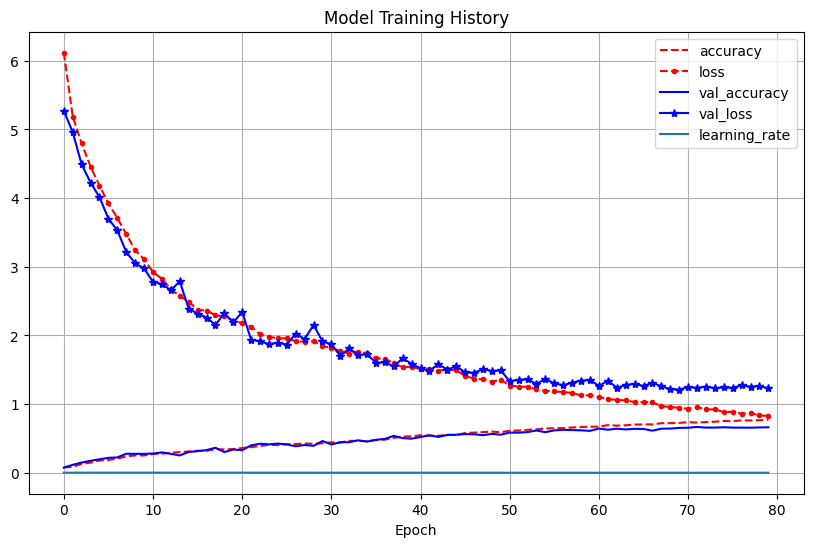

In [10]:
# define early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=1e-7, verbose=1)

# train model!!!
print("Training model...")
history = model.fit(train_padded, y_train_encoded, epochs=200, batch_size=32, validation_data=(val_padded, y_val_encoded), callbacks=[early_stopping, reduce_lr])
print("Training complete.")

# plot train/val accuracy/loss
history_df = pd.DataFrame(history.history)
history_df.plot(figsize=(10, 6), grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
plt.title("Model Training History")
plt.show()

In [11]:
# --- Get Predictions for the Validation Set ---

# 1. Get the raw probability "votes" from the model
# The model will output an array of shape (num_samples, 18)
val_probabilities = model.predict(val_padded)

# 2. Find the index (the class) with the highest probability
# for each sample. This is your final 'y_pred' for the
# validation set.
y_pred_val = np.argmax(val_probabilities, axis=1)

# Now you can use y_pred_val to compare against y_val_encoded
print("First 10 Validation Predictions:")
print(y_pred_val[:10])

print("\nFirst 10 True Validation Labels:")
print(y_val_encoded[:10])

from sklearn.metrics import classification_report

# --- THIS IS THE FIX ---

# 1. Get the class names (which are integers, e.g., [0, 1, 2])
gesture_names_int = label_encoder.classes_

# 2. Convert that array of integers into an array of strings
gesture_names_str = [str(name) for name in gesture_names_int]

# --- END OF FIX ---


# 3. Compare the true labels (y_val_encoded) to your model's predictions (y_pred_val)
#    We now pass the list of strings (gesture_names_str) to target_names.
report = classification_report(y_val_encoded, y_pred_val, target_names=gesture_names_str)

print(report)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
First 10 Validation Predictions:
[ 0 16 14 11  0  0  7  6  3  3]

First 10 True Validation Labels:
[ 0 15 14 13  0  0  7  3  1  3]
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       123
           1       0.49      0.57      0.53       127
           2       1.00      0.95      0.98        22
           3       0.48      0.40      0.44       121
           4       0.52      0.48      0.50       118
           5       1.00      0.95      0.98        22
           6       0.62      0.64      0.63       131
           7       0.62      0.74      0.67       122
           8       1.00      1.00      1.00        30
           9       0.47      0.44      0.45       121
          10       0.61      0.53      0.57       126
          11       0.28      0.96      0.43        27
          12       0.94      0.90      0.92        90
          13       0.50      0.03      0.05        39
          14      

## TODO

- get a prediction (and evaluate accuracy), comparing with dummy (read up on dummy classifier prediction...)
- tweak parameters and experiment, filter counts, etc.
- run through CNN more than once?
- model tuning
- final evaluation (using Kaggle evaluation metric) - separate script file?
- diagram(s) to display pre-processing, training, post-processing, etc.
- show to Ted (or Ryan) for feedback sometime
- plot prediction results on a confusion matrix, comparing true labels (test set) to predicted labels. See example from Ryan's slides for inspiration

Other ideas:
- mixup augmentation
- temporal dropout
- "attention score"
- post-processing/ accuracy evaluation condition (90% accuracy filter)
- "multi-head attention"
- ensembling

# WOW! Val accuracy of 0.675!